### ISO 281 Bearing Life Calculation Example
___

Calculate L10 life (rolling contact fatigue) using ISO 281 method - Fatigue Life estimation

#### Standard Libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import glob
import os
import scipy.stats as ss
pd.options.mode.chained_assignment = None   # off with setwithcopy warning
plt.rcParams["font.family"] = "Times New Roman" # Matplotlib font

#### Classes module

In [37]:
import classes_funcs as cf

___

#### Program Run

##### Choose file locations for loading data and column headers

In [38]:
file_location_fld = r'C:\Users\FREWIN\OneDrive - DNV GL\Atlantis\Runs\Damage endurance\Excel files\Flood' 
file_location_ebb = r'C:\Users\FREWIN\OneDrive - DNV GL\Atlantis\Runs\Damage endurance\Excel files\Ebb' 
cols = 'Time','PS deg','Fxy','Fz','My'

##### Bearing design parameters

In [39]:
brg_design_parameter_desc = pd.DataFrame({'Parameter':['i','z','dw','alpha','dp','Pu','kind'],
                                          'Unit':['-','-','mm','degrees','mm','N','-'],'Description':['Number of rows','Number of elements in a row','Individual brg diameter',
                                                                                       'Contact angle','Pitch diameter','Fatigue limit','Type']})

In [40]:
brg_design_parameter_desc 

,Parameter,Unit,Description
0,i,-,Number of rows
1,z,-,Number of elements in a row
2,dw,mm,Individual brg diameter
3,alpha,degrees,Contact angle
4,dp,mm,Pitch diameter
5,Pu,N,Fatigue limit
6,kind,-,Type


#### Bearing designs

In [80]:
skf_8110 = cf.brg_design(i=1,z=31,dw=77.5,alpha=60,D=1465,d=1270,pu=800000,kind='roller',ca_manuf=5280000)   # create sk8110 bearing object
# skf_ll68 = cf.brg_design(i=1,z=31,dw=77.5,alpha=60,D=1465,d=1270,pu=800000,kind='roller',ca_manuf=5280000)   # create sk8110 bearing object
# skf_bt2b = cf.brg_design(i=1,z=31,dw=77.5,alpha=60,D=1465,d=1270,pu=800000,kind='roller',ca_manuf=5280000)   # create sk8110 bearing object
brgs = skf_8110 #,skf_ll68,skf_bt2b

##### Combine ebb and flood load cases with duty cycles (time spent at each load case)

In [81]:
fld_load_cases = cf.load_case_comb(file_location_fld,cols,brg_p=brgs.p,brg_dp=brgs.dp()) # flood load cases for each brg
ebb_load_cases = cf.load_case_comb(file_location_ebb,cols,brg_p=brgs.p,brg_dp=brgs.dp()) # ebb load cases for each brg
duty_cycles = [0.1224,0.1672,0.1672,0.1582,0.1582,0.1194,0.0806,0.0179,0.009,0.2189,0.2139,0.1244,0.1592,0.1194,0.0796,0.0299,0.0547]
t_profiles = cf.tidal_profile_comb(duty_cycles,[fld_load_cases.lc_df(),ebb_load_cases.lc_df()],brgs.p,brgs.ca_manuf,brgs.z)

##### Calculate bearing fatigue life

In [82]:
lifes = cf.life_calcs(t_profiles.Ca_osc(),t_profiles.dyn_equiv_osc(),'roller',brgs.dp(),'high cleanliness',brgs.pu,rel_level=90,use_ISO_correction='Yes')
l10_osc = lifes.L10_mill_osc()
l10_hr = lifes.L10_hrs(t_profiles.N_opm_ave())

In [83]:
l10_hr

0    1.621806e+06
Name: a1, dtype: float64

##### Force and ps movement distributions

In [65]:
#plt.hist(fld_load_cases.load_data()[0]['My'],bins=9)

#### Sensitivity analysis (bearing design)

In [89]:
def L10_calc(i,z,dw,alpha,D,d,pu,kind,ca_manuf):
    # calculate L10 values (for sensitivity analysis)
    brg = cf.brg_design(i,z,dw,alpha,D,d,pu,kind,ca_manuf)
    flc = cf.load_case_comb(file_location_fld,cols,brg_p=brg.p,brg_dp=brg.dp()) # flood load cases for each brg
    elc = cf.load_case_comb(file_location_ebb,cols,brg_p=brg.p,brg_dp=brg.dp()) # ebb load cases for each brg
    duty_cycles = [0.1224,0.1672,0.1672,0.1582,0.1582,0.1194,0.0806,0.0179,0.009,0.2189,0.2139,0.1244,0.1592,0.1194,0.0796,0.0299,0.0547]
    t_profiles = cf.tidal_profile_comb(duty_cycles,[flc.lc_df(),elc.lc_df()],brg.p,brg.ca_manuf,brg.z)
    lifes = cf.life_calcs(t_profiles.Ca_osc(),t_profiles.dyn_equiv_osc(),'roller',brg.dp(),'high cleanliness',brg.pu,rel_level=90,use_ISO_correction='Yes')
    l10_osc = lifes.L10_mill_osc()
    l10_hr = lifes.L10_hrs(t_profiles.N_opm_ave())
    return l10_osc,l10_hr

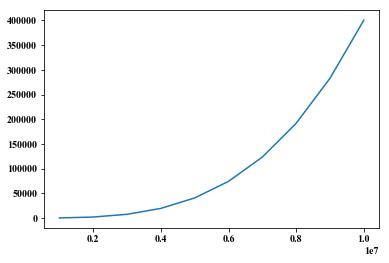

In [93]:
ca_s = np.linspace(1000000,10000000,10)
L10_ca = [L10_calc(i=1,z=31,dw=77.5,alpha=60,D=1465,d=1270,pu=800000,kind='roller',ca_manuf=ca_s[i])[1] for i in range(len(ca_s))]
fig,ax = plt.subplots()
_=ax.plot(ca_s,L10_ca)

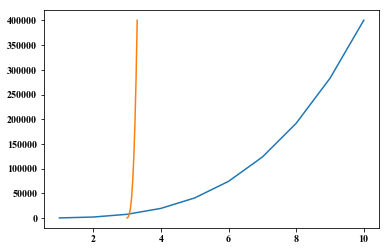

In [105]:
ca_pe_ratio = np.linspace(1,10,10)
a_iso_ = np.linspace(0.05,0.2,10)
a_1_ = np.linspace(1,1,10)
p_ = np.linspace(3,3.3,10)
l10_ = a_1_*a_iso_*(ca_pe_ratio)**p_
fig,ax = plt.subplots()
_=ax.plot(ca_pe_ratio,L10_ca)
_=ax.plot(p_,L10_ca)

---

#### Reliability Plots

In [ ]:
### assuming Beta param of 1.5, Eta is calculated using Weibull CDF and L10 number

In [107]:
from scipy import optimize

In [124]:
def unreliability(eta):
    # function to solve
    return 0.9-(np.exp((-48000/eta)**1.5))

In [129]:
def reliability(time,beta,eta):
    # calculate reliability func based on provided beta,eta
    return np.exp(-(time/eta)**beta)

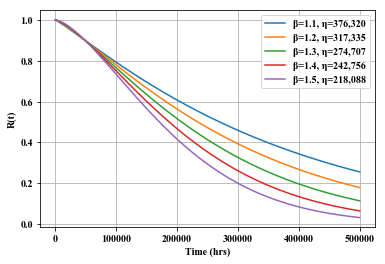

In [143]:
wbl_params_df = pd.DataFrame({'Beta':[1.1,1.2,1.3,1.4,1.5],'Eta':[376320,317335,274707,242756,218088]})
time = np.linspace(1,500000,1000)
beta = 1.5
eta = 218088
fig,ax=plt.subplots()
labels = 'β=1.1, η=376,320','β=1.2, η=317,335','β=1.3, η=274,707','β=1.4, η=242,756','β=1.5, η=218,088'
for i in range(len(wbl_params_df)):
    ax.plot(time,reliability(time,wbl_params_df.iloc[i,0],wbl_params_df.iloc[i,1]),label=labels[i])
_=ax.set(xlabel='Time (hrs)',ylabel='R(t)')
_=plt.grid()
_=plt.legend()
#_=plt.savefig(fname='pof_rel_func')

#### Distribution of Bearing Flapwise moment

In [ ]:
def log_norm_fit(data):
    # fit lognormal dist
    shape,loc,scale = ss.lognorm.fit(data/1000000)
    rvs = ss.lognorm.rvs(s=shape,loc=loc,scale=scale,size=len(data))
    pdf = ss.lognorm.pdf(np.sort(rvs),s=shape,loc=loc,scale=scale)
    return {'pdf':pdf,'rvs':np.sort(rvs)}

In [ ]:
My_fld_data = [fld_load_cases.load_data()[i]['My'] for i in range(len(fld_load_cases.load_data()))]
My_ebb_data = [ebb_load_cases.load_data()[i]['My'] for i in range(len(ebb_load_cases.load_data()))]
Myf_pdf = log_norm_fit(pd.concat(My_fld_data))
Mye_pdf = log_norm_fit(pd.concat(My_ebb_data))

In [ ]:
fig,ax = plt.subplots()
_=ax.plot(Myf_pdf['rvs'],Myf_pdf['pdf'],label='Flood Tide')
_=ax.plot(Mye_pdf['rvs'],Mye_pdf['pdf'],label='Ebb Tide')
_=plt.legend()
_=ax.set(xlabel='My MN',ylabel='PDF')

In [ ]:
fld_lc.lc_df(brg.dp)['Speed opm'].mean(),ebb_lc.lc_df(brg.dp)['Speed opm'].mean()